In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

2023-01-21 15:13:42.711677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 15:13:43.295394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 15:13:43.295415: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-21 15:13:45.312034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
def removeIdentifierFile(path):
    for file in os.listdir(path):
        if file.find(".Identifier") != -1:
            os.remove(os.path.join(path, file))

In [ ]:
import os, random

raw_imposters_folder = "imposters"
raw_valid_user_folder = "valid_user"

removeIdentifierFile(raw_imposters_folder)
removeIdentifierFile(raw_valid_user_folder)

img_count = 500 # img taken from each class

imposter_filenames = random.sample(os.listdir(raw_imposters_folder), img_count)
valid_user_filenames = random.sample(os.listdir(raw_valid_user_folder), img_count)

train_valid_user_folder = "train/valid_user"
train_imposters_folder = "train/imposters"

Path(train_valid_user_folder).mkdir(parents=True, exist_ok=True)
Path(train_imposters_folder).mkdir(parents=True, exist_ok=True)

test_valid_user_folder = "test/valid_user"
test_imposters_folder = "test/imposters"

Path(test_valid_user_folder).mkdir(parents=True, exist_ok=True)
Path(test_imposters_folder).mkdir(parents=True, exist_ok=True)


In [ ]:
class_training_size = int(img_count * 0.9)

count = 0
for imposter_filename in imposter_filenames[:class_training_size]:
    shutil.copy(os.path.join(raw_imposters_folder, imposter_filename), os.path.join(train_imposters_folder, imposter_filename))
    count += 1

count = 0
for imposter_filename in imposter_filenames[class_training_size:]:
    shutil.copy(os.path.join(raw_imposters_folder, imposter_filename), os.path.join(test_imposters_folder, imposter_filename))


for valid_user_filename in valid_user_filenames[:class_training_size]:
    shutil.copy(os.path.join(raw_valid_user_folder, valid_user_filename), os.path.join(train_valid_user_folder, valid_user_filename))

for valid_user_filename in valid_user_filenames[class_training_size:]:
    shutil.copy(os.path.join(raw_valid_user_folder, valid_user_filename), os.path.join(test_valid_user_folder, valid_user_filename))

removeIdentifierFile(train_imposters_folder)
removeIdentifierFile(test_imposters_folder)
removeIdentifierFile(train_valid_user_folder)
removeIdentifierFile(test_valid_user_folder)


In [ ]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("train",
    target_size=(150,150),
    batch_size = 32,
    class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("test",
    target_size=(150,150),
    batch_size =32,
    class_mode = 'binary')

In [ ]:
test_dataset.class_indices


In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation='relu'))

model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit_generator(train_dataset,
    steps_per_epoch = 250,
    epochs = 10,
    validation_data = test_dataset
)

model.save('classifier')

In [6]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    print(img1)
    model = tf.keras.models.load_model('classifier')

    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("valid",fontsize=30)
    elif val == 0:
        plt.xlabel("user",fontsize=30)




<PIL.Image.Image image mode=RGB size=150x150 at 0x7EFE4C3DE460>
1/1 [==============================] - 0s 91ms/step
[[1.]]


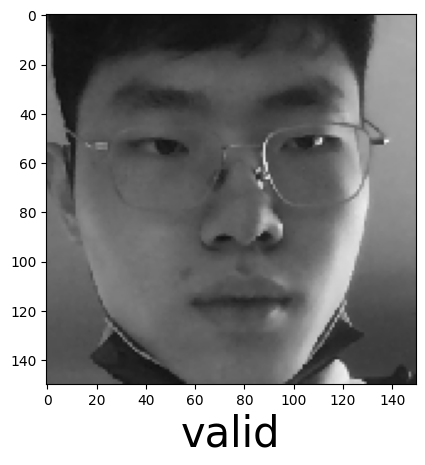

In [7]:
predictImage("valid_user/5.png")